In [11]:
import pandas as pd

# 1. Prepare Fine-Tuning Data

In [16]:
questions = [
    "What are the key features or attributes in the user_info and user_history tables that we should consider when measuring user similarity?",
    "How can we incorporate categorical variables, such as user demographics, into the calculation of user similarity?",
    "Is there a preferred method for handling temporal aspects when analyzing user history for similarity with current user information?",
    "Should we normalize or standardize numerical features before computing user similarity, and if so, how?",
    "Can you provide guidance on handling missing data in either the user_info or user_history table during similarity analysis?",
    "What tools or libraries do you recommend for efficiently calculating and visualizing user similarity between the two tables?",
    "Are there any privacy or security considerations we should be aware of when performing user similarity analysis on these tables?",
    "How do we interpret the results of user similarity analysis, and is there a threshold for defining significant similarity?",
    "In what scenarios would cosine similarity or Euclidean distance be more suitable for comparing user profiles between the two tables?",
    "What is the vector distance between user X in user_info and user Y in user_history"
]

context = """
CREATE TABLE user_info (
    UserId INT PRIMARY KEY,
    CallDuration FLOAT,
    DataCounter FLOAT,
    SMS FLOAT
);

Sample Data : 
| UserId | CallDuration | DataCounter | SMS |
|--------|--------------|-------------|-----|
| 1      | 0.0000333    | 0.2         | 0.1 |
| 2      | 0.5          | 0.4         | 0.4 |
| 3      | 1            | 0.8         | 0.9 |


CREATE TABLE user_history (
    UserId INT PRIMARY KEY,
    CallDuration FLOAT,
    DataCounter FLOAT,
    SMS FLOAT
);

Sample Data : 
| UserId | CallDuration | DataCounter | SMS |
|--------|--------------|-------------|-----|
| 5      | 0.93         | 0.4         | 0.7 |
| 6      | 0.83         | 0.3         | 0.6 |
| 7      | 0.73         | 0.5         | 0.7 |
"""

answer = """
    SELECT target_id, reference_id, distancetype, cast(distance as decimal(36,8)) as distance FROM TD_VECTORDISTANCE (
    ON user_infor AS TargetTable
    ON user_history AS ReferenceTable DIMENSION
    USING
    TargetIDColumn('userid')
    TargetFeatureColumns('CallDuration','DataCounter','SMS')
    RefIDColumn('userid')
    RefFeatureColumns('CallDuration','DataCounter','SMS')
    DistanceMeasure('euclidean','cosine','manhattan')
    topk(2)
    ) AS dt order by 3,1,2,4;
"""

In [84]:
df_fine_tuning_data = pd.DataFrame(
    {
        "questions": questions,
        "context": [context] * len(questions),
        "completion": [answer] * len(questions)
    }
)
df_fine_tuning_data["prompt"] = df_fine_tuning_data["questions"] + df_fine_tuning_data["context"]

df_fine_tuning_data.replace(r'\r?\n', ' ', regex=True, inplace=True)

In [85]:
json_lines = df_fine_tuning_data.apply(lambda row: f'{{"prompt": "{row["prompt"]}", "completion": "{row["completion"]}"}}', axis=1)

with open('finetune_data.jsonl', 'w') as file:
    file.write(json_lines.str.cat(sep='\n'))

In [94]:
json_lines

0    {"prompt": "What are the key features or attri...
1    {"prompt": "How can we incorporate categorical...
2    {"prompt": "Is there a preferred method for ha...
3    {"prompt": "Should we normalize or standardize...
4    {"prompt": "Can you provide guidance on handli...
5    {"prompt": "What tools or libraries do you rec...
6    {"prompt": "Are there any privacy or security ...
7    {"prompt": "How do we interpret the results of...
8    {"prompt": "In what scenarios would cosine sim...
9    {"prompt": "What is the vector distance betwee...
dtype: object

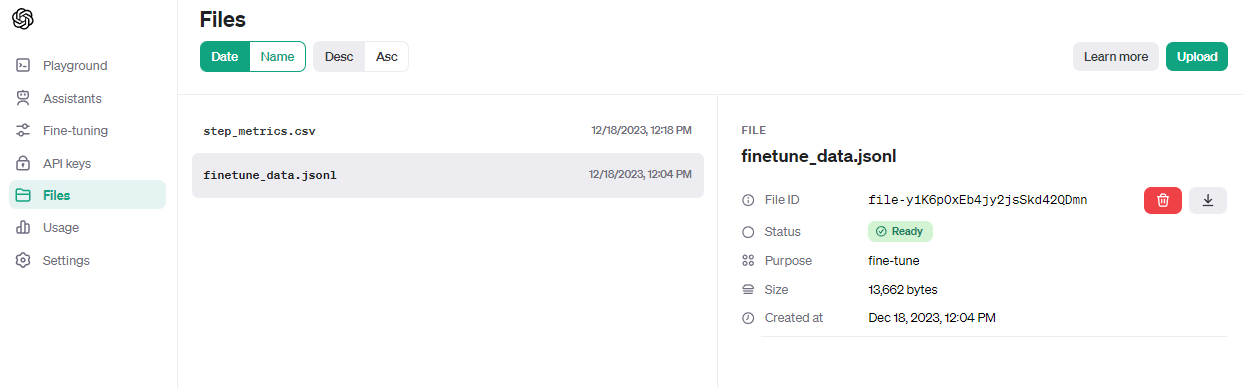

# 2. Fine-tuning

In [97]:
from openai import OpenAI
import os 


# 1. Upload training file
client = OpenAI(api_key=os.getenv("OPENAI_API"))

filepath = "./finetune_data.jsonl"

train_file = client.files.create(
  file=open(filepath, "rb"),
  purpose="fine-tune"
)

**Start Fine-tuning**

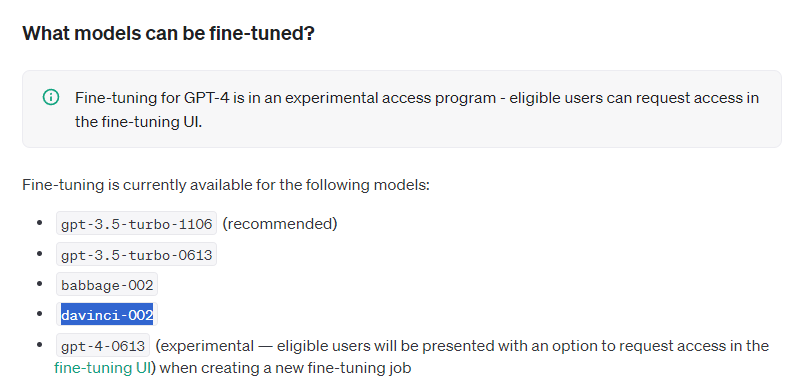

Only fews model able to Fine-tuning. Not all models

In [106]:
client.fine_tuning.jobs.create(
  training_file=train_file.id, 
  model="davinci-002"
)

FineTuningJob(id='ftjob-kE5kR2p49TBUTrAjsEAC7kAF', created_at=1702869383, error=None, fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='davinci-002', object='fine_tuning.job', organization_id='org-9KX0bYXo5VUDoE5QIbO7rBzm', result_files=[], status='validating_files', trained_tokens=None, training_file='file-y1K6pOxEb4jy2jsSkd42QDmn', validation_file=None)

Fine-tuning UI

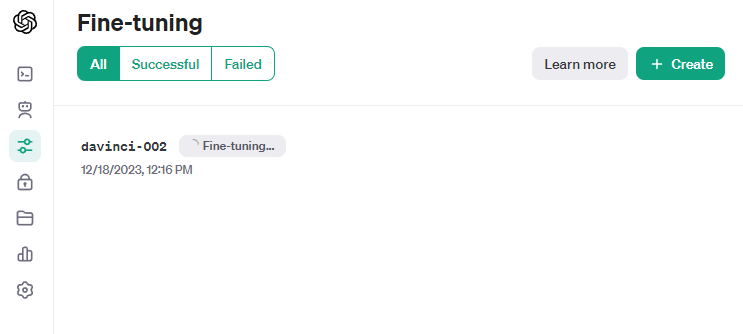

Kết quả sau khi thực hiện Fine-Tuning

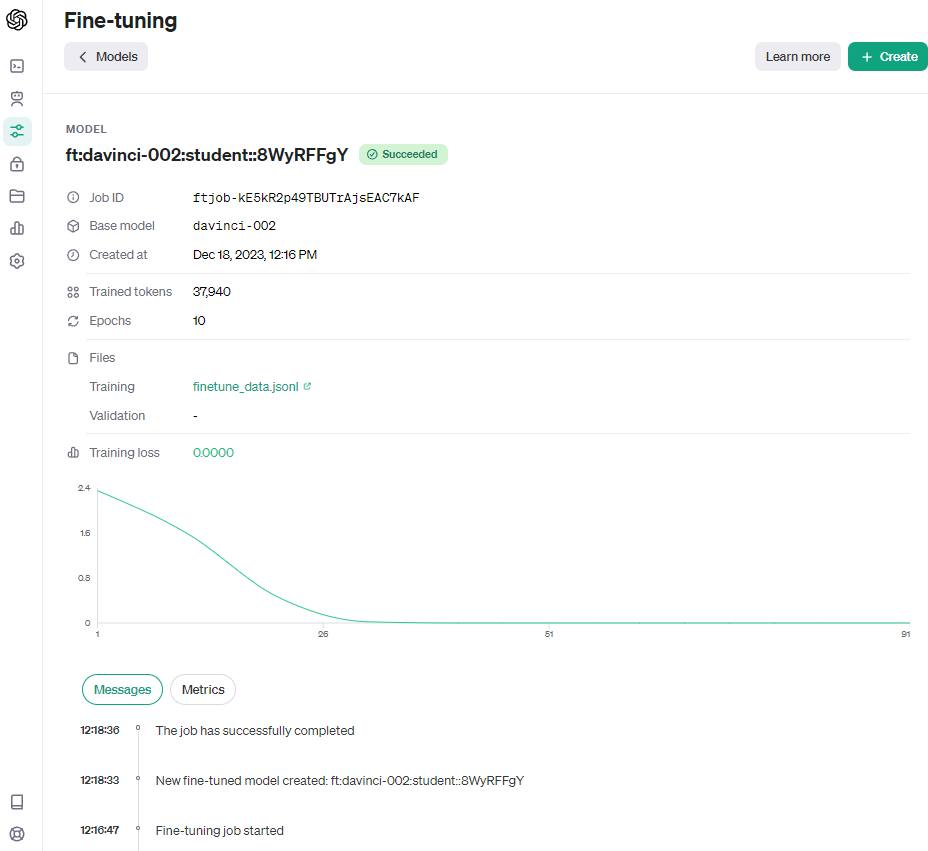

# 3. Using Fine-Tuning model

In [109]:
client.completions.create(
    model="ft:davinci-002:student::8WyRFFgY",
    prompt="Hello"
)

Completion(id='cmpl-8WyetfHCLevdIpnCUS39Nq7ZLnQHl', choices=[CompletionChoice(finish_reason='length', index=0, logprobs=None, text=" Guys! i'm youkai!!!!!!\n\nI started this thread as we should")], created=1702870359, model='ft:davinci-002:student::8WyRFFgY', object='text_completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=16, prompt_tokens=1, total_tokens=17))

In [166]:
question = """
You are an agent designed to interact with a Teradata database.
Given an input question, create a syntactically correct teradata query to run, then look at the results of the query and return the answer.


Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [sql_db_query, sql_db_schema, sql_db_list_tables, sql_db_query_checker]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question : What are the key features or attributes in the user_info and user_history tables that we should consider when measuring user similarity?
Thought: I should look at the tables in the database to see what I can query.  Then I should query the schema of the most relevant tables.
Observation: user_info, user_history
CREATE TABLE user_info (
    UserId INT PRIMARY KEY,
    CallDuration FLOAT,
    DataCounter FLOAT,
    SMS FLOAT
);

Sample Data : 
| UserId | CallDuration | DataCounter | SMS |
|--------|--------------|-------------|-----|
| 1      | 0.0000333    | 0.2         | 0.1 |
| 2      | 0.5          | 0.4         | 0.4 |
| 3      | 1            | 0.8         | 0.9 |


CREATE TABLE user_history (
    UserId INT PRIMARY KEY,
    CallDuration FLOAT,
    DataCounter FLOAT,
    SMS FLOAT
);

Sample Data : 
| UserId | CallDuration | DataCounter | SMS |
|--------|--------------|-------------|-----|
| 5      | 0.93         | 0.4         | 0.7 |
| 6      | 0.83         | 0.3         | 0.6 |
| 7      | 0.73         | 0.5         | 0.7 |
"""

In [167]:
print(question)


You are an agent designed to interact with a Teradata database.
Given an input question, create a syntactically correct teradata query to run, then look at the results of the query and return the answer.


Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [sql_db_query, sql_db_schema, sql_db_list_tables, sql_db_query_checker]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question : What are the key features or attributes in the user_info and user_history tables that we should consider when measuring user similarity?
Thought: I should look at the tables in the database to see what I can query.  Then I should query the schema of the most relevant tables.
Observation: 

In [160]:
result = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": question}
  ]
)

In [150]:
print(result.choices[0].text)

 Action: sql_db_query Action Input: SELECT * FROM user_info


In [151]:
result = client.completions.create(
    model="ft:davinci-002:student::8WyRFFgY",
    prompt=question
)

In [152]:
print(result.choices[0].text)

     SELECT target_id, reference_id, distancetype, cast(distance as decimal


In [164]:
print(result.choices[0].message.content)

Thought: To determine the key features or attributes in the user_info and user_history tables that should be considered when measuring user similarity, I should query the schemas of both tables.

Action: sql_db_schema
Action Input: user_info
Observation: The columns in the user_info table are UserId, CallDuration, DataCounter, and SMS.

Thought: Now I will query the schema of the user_history table.

Action: sql_db_schema
Action Input: user_history
Observation: The columns in the user_history table are UserId, CallDuration, DataCounter, and SMS.

Thought: From the observations, the key features or attributes in both the user_info and user_history tables that should be considered when measuring user similarity are UserId, CallDuration, DataCounter, and SMS.

Final Answer: The key features or attributes in the user_info and user_history tables that should be considered when measuring user similarity are UserId, CallDuration, DataCounter, and SMS.


In [170]:
context = """
SELECT target_id, reference_id, distancetype, cast(distance as decimal(36,8)) as distance FROM TD_VECTORDISTANCE (
ON target_mobile_data_dense AS TargetTable
ON ref_mobile_data_dense AS ReferenceTable DIMENSION
USING
TargetIDColumn('userid')
TargetFeatureColumns('CallDuration','DataCounter','SMS')
RefIDColumn('userid')
RefFeatureColumns('CallDuration','DataCounter','SMS')
DistanceMeasure('euclidean','cosine','manhattan')
topk(2)
) AS dt order by 3,1,2,4;
"""

In [171]:
context

"\nSELECT target_id, reference_id, distancetype, cast(distance as decimal(36,8)) as distance FROM TD_VECTORDISTANCE (\nON target_mobile_data_dense AS TargetTable\nON ref_mobile_data_dense AS ReferenceTable DIMENSION\nUSING\nTargetIDColumn('userid')\nTargetFeatureColumns('CallDuration','DataCounter','SMS')\nRefIDColumn('userid')\nRefFeatureColumns('CallDuration','DataCounter','SMS')\nDistanceMeasure('euclidean','cosine','manhattan')\ntopk(2)\n) AS dt order by 3,1,2,4;\n"